In [ ]:
#!kaggle competitions download -c planet-understanding-the-amazon-from-space

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
import numpy as np
import tensorflow as tf
from keras.layers import BatchNormalization
from tensorflow import keras
# from keras import Dense, Flatten, Activation
# from keras import Conv2D
# from keras import Dropout, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD

## Let's first read the data from the training set

In [2]:
train_data_nolabel = pd.read_csv('train_v2.csv/train_v2.csv')
train_data_nolabel.head()

FileNotFoundError: [Errno 2] No such file or directory: 'train_v2.csv/train_v2.csv'

One can see that the data has an image name and tags.

Let's isolate the tags in categories: weather and ground type.

In [3]:
atmospheric_conditions = ['partly_cloudy', 'haze', 'cloudy', 'clear']
land_categories = {
    "primary": np.zeros(train_data_nolabel.shape[0]),
    "road":np.zeros(train_data_nolabel.shape[0]),
    "water":np.zeros(train_data_nolabel.shape[0]),
    "habitation":np.zeros(train_data_nolabel.shape[0]),
    "agriculture":np.zeros(train_data_nolabel.shape[0]),
    "cultivation":np.zeros(train_data_nolabel.shape[0]),
    "bare_ground":np.zeros(train_data_nolabel.shape[0]),
    "selective_logging":np.zeros(train_data_nolabel.shape[0]),
    "artisinal_mine":np.zeros(train_data_nolabel.shape[0]),
    "slash_burn":np.zeros(train_data_nolabel.shape[0]),
    "blow_down":np.zeros(train_data_nolabel.shape[0]),
    "blooming":np.zeros(train_data_nolabel.shape[0]),
    "conventional_mine":np.zeros(train_data_nolabel.shape[0])}
atmospheric_conditions_list = [[element for element in tag.split() if element in atmospheric_conditions] for tag in train_data_nolabel['tags']]

for i in range(len(train_data_nolabel.tags)):
    for element in train_data_nolabel.tags[i].split():
        if element in land_categories.keys():
            land_categories[element][i] = 1

train_data_nolabel['weather_tags'] = [''.join(tag) for tag in atmospheric_conditions_list]
train_data_nolabel = pd.concat([train_data_nolabel, pd.DataFrame(land_categories, dtype=int)], axis=1)
train_data_nolabel.head()


,image_name,tags,weather_tags,primary,road,water,habitation,agriculture,cultivation,bare_ground,selective_logging,artisinal_mine,slash_burn,blow_down,blooming,conventional_mine
0,train_0,haze primary,haze,1,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,clear,1,0,1,0,1,0,0,0,0,0,0,0,0
2,train_2,clear primary,clear,1,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,clear,1,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,clear,1,1,0,1,1,0,0,0,0,0,0,0,0


(256, 256, 4)


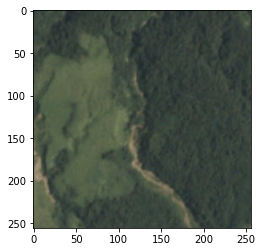

In [9]:
img = imgplt.imread('train-jpg/train_1.jpg')
imgplot = plt.imshow(img)
plt.show()

In [5]:
train_data_nolabel.describe()

,primary,road,water,habitation,agriculture,cultivation,bare_ground,selective_logging,artisinal_mine,slash_burn,blow_down,blooming,conventional_mine
count,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000,40479.000000
mean,0.926727,0.199387,0.183083,0.090417,0.304232,0.110601,0.021295,0.008399,0.008375,0.005163,0.002421,0.008202,0.002470
std,0.260587,0.399545,0.386739,0.286782,0.460087,0.313641,0.144368,0.091264,0.091131,0.071670,0.049145,0.090193,0.049642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we will create a new dataframe with the labels for the images.

In [6]:
is_deforested_list = []
for i in range(len(train_data_nolabel)):
    if train_data_nolabel.primary[i] == 1:
        if train_data_nolabel.road[i] == 1 or train_data_nolabel.habitation[i] == 1 or train_data_nolabel.agriculture[i] == 1 or train_data_nolabel.cultivation[i] == 1 or train_data_nolabel.selective_logging[i] == 1 or train_data_nolabel.artisinal_mine[i] == 1 or train_data_nolabel.slash_burn[i] == 1 or train_data_nolabel.conventional_mine[i] == 1:
            is_deforested_list.append(1)
        else:
            is_deforested_list.append(0)
    else:
        is_deforested_list.append(1)
train_df = pd.DataFrame(train_data_nolabel.image_name)
train_df['weather'] = train_data_nolabel.weather_tags
train_df['is_deforested'] = is_deforested_list

train_df.head()

,image_name,weather,is_deforested
0,train_0,haze,0
1,train_1,clear,1
2,train_2,clear,0
3,train_3,clear,0
4,train_4,clear,1


In [24]:
#x_train = [imgplot.imread(f'train-jpg/{train_df.image_name[i]}.jpg') for i in range(len(train_df))]
loc = 'train-jpg/'
x_train = np.array([imgplt.imread(loc + train_df.image_name[i] + '.jpg') for i in range(10000)])

In [26]:
print(x_train.shape)
x_train = x_train.astype('float32') / 255

(10000, 256, 256, 4)


In [39]:
y_train = train_df.is_deforested.values[:10000]
x_test = np.array([imgplt.imread(loc + train_df.image_name[i] + '.jpg') for i in range(10000, 12000)])
x_test = x_test.astype('float32') / 255
print(x_test.shape)
y_test = train_df.is_deforested.values[10000:12000]

(2000, 256, 256, 4)


Let's build the model


In [40]:
def cnn_model(input_shape, num_classes):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [45]:
model = cnn_model(x_train.shape[1:], 1)


C:\Users\black\.conda\envs\ox\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [46]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 32)      1184      
                                                                 
 activation_12 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 dropout_6 (Dropout)         (None, 254, 254, 32)      0         
                                                                 
 activation_13 (Activation)  (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                      

In [47]:
def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10, file_name: str = None):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size:
    :param int epochs:
    """
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', min_delta=0, patience=2, mode='auto')

    model.fit(x, y, batch_size=batch_size, epochs=epochs,
              validation_data=(x_test, y_test), shuffle=True, callbacks=[early_stopping])

    if file_name is not None:
        model.save(file_name)

Train the model

In [48]:
train_model(model, x_train, y_train, x_test, y_test, epochs=10, file_name='model.h5')

Epoch 1/10
 30/313 [=>............................] - ETA: 15:17 - loss: 0.0000e+00 - accuracy: 0.4688

KeyboardInterrupt: 

In [2]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0']


In [4]:
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print(tf.__version__)
# my output was => 1.13.1


3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:34:17) [MSC v.1929 64 bit (AMD64)]
2.8.0
